In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install transformers

In [3]:
# !rm *.pt

In [4]:
import numpy as np
import pandas as pd

from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
import torch

from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import random
import os
import json

from sklearn.metrics import roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt

In [5]:
VALID_SIZE = 0.1
EPOCHS = 10
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
MAX_LEN = 64
SEED_VALUE = 42

In [6]:
# to get consistant result
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)
torch.cuda.manual_seed_all(SEED_VALUE)

In [7]:
with open('merged.json') as input_file:
  data = json.load(input_file)

len(data)

2100

In [8]:
# toknoization 
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

In [9]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Using gpu")
else:
  device = torch.device("cpu")
  print("Using Cpu")

Using gpu


In [10]:
train_data, valid_data = train_test_split(data,random_state = SEED_VALUE)

In [11]:
# split text and lable of train data
train_texts = [d["text"] for d in train_data]
train_labels = [d["label"].lower()=="true" for d in train_data]

In [12]:
# percentatge of train class labled as true
np.mean(train_labels)

0.37714285714285717

In [13]:
valid_texts = [d["text"] for d in valid_data]
valid_labels = [d["label"].lower()=="true" for d in valid_data]

In [14]:
# percentatge of val class labled as true
np.mean(valid_labels)

0.4

In [15]:
# toknize and change to intiger 
train_input_ids = [None for i in range(len(train_texts))]
for i in tqdm.trange(len(train_texts)):
  sent = train_texts[i]
  encoded = tokenizer.encode(sent, add_special_tokens=True)
  train_input_ids[i] = encoded

100%|██████████| 1575/1575 [00:01<00:00, 1138.66it/s]


In [16]:
valid_input_ids = [None for i in range(len(valid_texts))]
for i in tqdm.trange(len(valid_texts)):
  sent = valid_texts[i]
  encoded = tokenizer.encode(sent, add_special_tokens=True)
  valid_input_ids[i] = encoded

100%|██████████| 525/525 [00:00<00:00, 1093.76it/s]


In [17]:
# print length of tweet length with max length 
n = 0
for input in train_input_ids:
  if n< len(input):
    n= len(input)
print(n)

113


In [18]:
# changnge the sentences to fixed size/consistant size / padding
train_input_ids = pad_sequences(train_input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
valid_input_ids = pad_sequences(valid_input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")

In [19]:
# mask the paddeed valaue/ to avoiud the effect of zero values/padding values
train_attention_masks = [None for i in range(len(train_input_ids))]
for i in tqdm.trange(len(train_input_ids)):
  sent = train_input_ids[i]
  att_mask = [int(token_id > 0) for token_id in sent]
  train_attention_masks[i] = att_mask

100%|██████████| 1575/1575 [00:00<00:00, 24626.94it/s]


In [20]:
valid_attention_masks = [None for i in range(len(valid_input_ids))]
for i in tqdm.trange(len(valid_input_ids)):
  sent = valid_input_ids[i]
  att_mask = [int(token_id > 0) for token_id in sent]
  valid_attention_masks[i] = att_mask

100%|██████████| 525/525 [00:00<00:00, 22662.35it/s]


In [21]:
# change to tensor 
train_inputs = torch.tensor(train_input_ids)
valid_inputs = torch.tensor(valid_input_ids)
train_labels = torch.tensor(train_labels).long()
valid_labels = torch.tensor(valid_labels).long()
train_masks = torch.tensor(train_attention_masks)
valid_masks = torch.tensor(valid_attention_masks)

In [22]:
# create tensor dataset
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = TRAIN_BATCH_SIZE)

In [23]:
valid_data = TensorDataset(valid_inputs, valid_masks, valid_labels)
valid_sampler = RandomSampler(valid_data)
valid_dataloader = DataLoader(valid_data,  batch_size = VALID_BATCH_SIZE,shuffle=False)

In [24]:
# create the bert classification model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2, output_attentions=False, output_hidden_states = False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [25]:
# copy the model to device to cpu/Gpu
model = model.to(device)

In [26]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [27]:
def accuracy(preds, labels):
  
  pred_flatten =(preds[:,1]>0.5).flatten().astype("int")
  labels_flatten = labels.flatten().astype("int")
  
  return (pred_flatten==labels_flatten).astype("float").sum()/len(labels_flatten)

In [28]:
def train_one_epochs(model, loader, optimizer):
  model.train()
  ema_loss = None
  t = tqdm.notebook.tqdm(loader)
  losses = []
  for  inputs, masks, labels in t:
      inputs = inputs.to(device)
      masks = masks.to(device)
      labels = labels.to(device)

      outputs = model(inputs, token_type_ids=None, attention_mask=masks, labels = labels)
      
      loss = outputs[0]
      losses.append(loss.item())
      optimizer.zero_grad()
      if ema_loss is None:
        ema_loss = loss.item()
      else:
        ema_loss += 0.1 * (loss.item() - ema_loss)
      t.set_description("loss: {:.4f}".format(ema_loss))
      t.refresh()
      loss.backward()
      optimizer.step()
  return np.mean(losses)

      

In [29]:
def test_model(model, loader):
  model.eval()
  with torch.no_grad():
    accs = []
    t = tqdm.notebook.tqdm(loader)
    for  inputs, masks, labels in t:
        inputs = inputs.to(device)
        masks = masks.to(device)
        

        outputs = model(inputs, token_type_ids=None, attention_mask=masks)
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = labels.numpy()
        batch_acc = accuracy(logits, label_ids)
        accs.append(batch_acc)
        val_acc = np.mean(accs)
        t.set_description("val_acc: {:.4f}".format(val_acc))
        t.refresh()
    return val_acc


In [30]:
def train_loop(model, train_loader, valid_loader, optimizer):
  losses = []
  valid_accs = []
  t = tqdm.notebook.trange(EPOCHS)
  prev_val_accuracy = 0
  for epoch in t:
    loss = train_one_epochs(model, train_loader, optimizer)
    losses.append(loss)
    valid_acc = test_model(model, valid_loader)
    if valid_acc > prev_val_accuracy:
      torch.save(model.state_dict(), 'best_model-{}-{:.2f}.pt'.format(epoch+1, valid_acc * 100))
      prev_val_accuracy = valid_acc

    valid_accs.append(valid_acc)
    
  return losses, valid_accs

In [31]:
losses, valid_accs = train_loop(model, train_dataloader, valid_dataloader, optimizer)

In [33]:
# choose best model
model.load_state_dict(torch.load("/content/best_model-10-84.93.pt"))

<All keys matched successfully>

In [34]:
# AUC of the model
predictions = []
targets = [] 
model.eval()
with torch.no_grad():
  t = tqdm.notebook.tqdm(valid_dataloader)
  for  inputs, masks, labels in t:
    inputs = inputs.to(device)
    masks = masks.to(device)
    outputs = model(inputs, token_type_ids=None, attention_mask=masks)
    logits = outputs[0]
    logits = logits.detach()[:,1]
    probs = torch.sigmoid(logits).cpu().tolist()
    predictions.extend(probs)
    targets.extend(labels.tolist())
  

In [ ]:
# print(targets)
# print(predictions)

In [35]:

fpr, tpr, thresholds = metrics.roc_curve(targets, predictions, pos_label=1)
auc = metrics.auc(fpr, tpr)


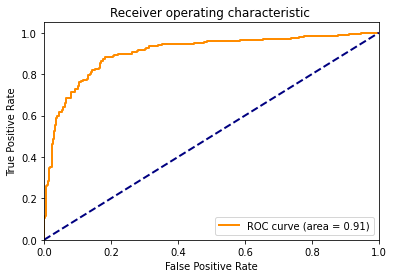

0.9055631141345426


In [36]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ')
plt.legend(loc="lower right")
plt.show()
print(auc)

In [37]:
# save the best model 
torch.save(model,"/content/drive/MyDrive/BDT_BEST_MODEL/best-model.pt")